In [3]:
%load_ext zipline
#%%
import talib
import zipline
import os
from zipline.api import order_target, record, symbol, order_target_percent
import pandas as pd 
from zipline.api import order, record, symbol, set_benchmark
from matplotlib import style
import matplotlib.pyplot as plt
from zipline.data.bundles import load
import pyfolio as pf
import empyrical
import numpy as np
from pandas import Timestamp
import matplotlib.pyplot as plt
from trading_calendars import get_calendar
from pathlib import Path
from time import time
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from zipline.finance import commission, slippage
import seaborn as sns

In [4]:
df = pd.read_csv('../data/daily/AMI.csv')

In [5]:
xx = df.close.pct_change().fillna(0).add(1).cumprod().sub(1)

# Portfolio Analysis
It is critical to demonstrate the efficacy of any portfolio through rigorous testing. This is fundamental to understanding the risk profile as well as the performance of the portfolio. We have created a package called pyfolio. pyfolio is a Python library for performance and risk analysis of financial portfolios, available on github here. It allows us to easily generate tear sheets to analyze the risk and performance of trading algorithms as well as return streams in general.

There are two main parts to a full pyfolio tearsheet. First, there are the performance statistics in table format. Useful metrics such as the annual return, market beta, and Sharpe ratio are all listed in this table. These metrics not only represent how well the strategy has performed during the time period of the backtest, they also show the risk-adjusted return as measured by the different ratios.

These metrics not only represent how well the strategy has performed during the time period of the backtest (annual rate of return), they also show the risk-adjusted return as measured by the different ratios. 

There are plots which help to visualize a variety of the performance metrics. For instance, the user can use the drawdown plots to quickly pinpoint the time periods in which the strategy performed the worst. In addition, it will help the user to see if the strategy is performing as it should - if a strategy is market neutral, but suffers significant drawdowns during crisis periods, then there are clearly issues with the strategy's design or implementation.

# Future returns prediction
Using the daily return predictions that we created using the regression model in the 3.0 mw notebook. Using a few simple technical factors, we predicted the returns for the next day for the 7 instruments that we are trading.

In [6]:
path = "../data/signals/lr_predicted_returns.csv" #updated with SENTIMENT & QUANTITIVE NFT data
data = pd.read_csv(path)
data = data.set_index(['Symbol', 'Date'], inplace=False)
data

actuals  predicted
Symbol Date                           
ADA    2021-09-20 -0.048375   0.019084
       2021-09-21  0.134664   0.031653
       2021-09-22  0.032319   0.020786
       2021-09-23 -0.019922   0.056849
       2021-09-24  0.015213   0.028074
...                     ...        ...
TFUEL  2022-03-16  0.022745   0.116089
       2022-03-17  0.021005   0.154950
       2022-03-18  0.010329   0.137294
       2022-03-19 -0.030225   0.128500
       2022-03-20  0.007903   0.075769

[1274 rows x 2 columns]

Transform the predictions table into wide format, with one ticker per column:

In [7]:
predictions = data.predicted.unstack(level=0)

Create the signals from the predicted future returns

In [8]:
long_signals = (predictions.where(predictions>0.01).rank(axis=1,ascending=False) <= 2).astype(int)
short_signals = (predictions.where(predictions<0).rank(axis=1) <= 2).astype(int)

Loading the bundle to print its values

In [38]:
#!zipline ingest --bundle universe
#!zipline clean -b universe --keep-last 1

In [37]:
bundle_name = 'universe'
now = Timestamp.utcnow()
bundle = load(bundle_name, os.environ, now)
symbols = set(str(asset.symbol) 
              for asset in bundle.asset_finder.retrieve_all(
                           bundle.asset_finder.equities_sids))

print('Our trading universe is:')
print(list(symbols))

Our trading universe is:
['MATIC', 'AMI', 'SOL', 'FLOW', 'MANA', 'AVAX', 'TFUEL', 'ADA']


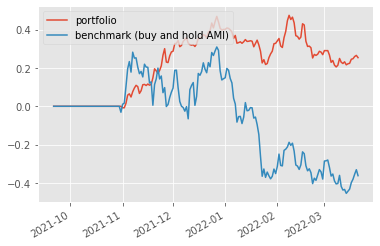

The portfolio's value went from 40000 to 50159.713177130005
The benchmark's value went from 40000 to 25504.182468597894


In [40]:
#Initial parameters
COINS = predictions.columns
status = [False]*len(COINS)
hold_days = [0]*len(COINS)
shortest_period = 10
initial_portfolio = 40000
longest_period = 40
holding_period = 18
start = pd.Timestamp('2021-09-20', tz='utc')
end = pd.Timestamp('2022-03-20', tz='utc')

#every buy or sell binance there is a fee 0.1% of the trade
commission_pct = 0.0001

#the spread for each transaction in terms of slippage is 0.2% 
slippage_impact = 0.0002

# Setup our variables
def initialize(context):
    
    #coin universe
    COINS = predictions.columns

    # make a list of symbols for the list of tickers
    context.coins = [symbol(s) for s in COINS]
    
    # create equal weights of each coin to hold in our portfolio
    context.target_pct_per_coin = 1.0/ len(context.coins)
    
    context.holding_days = {COINS[i]: hold_days[i] for i in range(len(COINS))}
    set_benchmark(symbol('AMI'))
    context.i = 0
    context.set_commission(commission.PerDollar(cost=commission_pct))
    context.set_slippage(slippage.FixedSlippage(spread=slippage_impact))
    
    
# Rebalance daily.
def handle_data(context, data):
    context.i += 1
    
    if context.i < longest_period:
        return
    
    # Load historical pricing data for the stocks, using daily frequncy and a rolling X days
    prices = data.history(context.coins, 'price', bar_count=longest_period, frequency="1d")
        

    j=0
    current_date = str(zipline.api.get_datetime()).split(' ')[0]
    
    #mask signals for today
    long_signals_vector = long_signals[long_signals.index == current_date ]
    short_signals_vector = short_signals[short_signals.index == current_date ]
    
    # Loop through our list of stocks
    for coin in context.coins:
        #today's price of the coin
        current_price = data.current(coin, 'price')
        
        current_position = context.portfolio.positions[coin].amount
        
        #access the signals
        long_signal_value = long_signals_vector[COINS[j]][0]
        short_signal_value = short_signals_vector[COINS[j]][0]
        
        #if we are holding this asset, increment the number of holding days by 1
        if current_position > 0:
            context.holding_days[COINS[j]] += 1
        #buy signal     
        if long_signal_value == 1 and current_position == 0: 
            order_target_percent(coin, context.target_pct_per_coin)
        #sell signal        
        if (short_signal_value ==1 and current_position > 0) or (context.holding_days[COINS[j]] == holding_period and current_position > 0):
            order_target_percent(coin, 0)
            context.holding_days[COINS[j]] = 0      
        j+=1

    record(SOL=data.current(symbol('SOL'), 'price'),
           TFUEL=data.current(symbol('TFUEL'), 'price'),
           MATIC=data.current(symbol('MATIC'), 'price'),
           FLOW=data.current(symbol('FLOW'), 'price'),
           MANA=data.current(symbol('MANA'), 'price'),
            ADA=data.current(symbol('ADA'), 'price'),
            AVAX=data.current(symbol('AVAX'), 'price'),
           AMI = data.current(symbol('AMI'), 'price'),
          )
    

perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
    capital_base=initial_portfolio, 
    handle_data = handle_data,
    trading_calendar=get_calendar('24/7'),
    data_frequency = 'daily', 
    bundle= bundle_name)

######################
style.use("ggplot")
perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.AMI.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark (buy and hold AMI)')
bmark_final = (perf.AMI.pct_change().fillna(0).add(1).cumprod().sub(1)[-1]*initial_portfolio) + initial_portfolio
plt.legend(loc=2)
plt.show()
print("The portfolio's value went from " + str(initial_portfolio) + " to " +  str(perf.portfolio_value[-1]))
print("The benchmark's value went from " + str(initial_portfolio) + " to " +  str(bmark_final))

Now, we want to understand the returns, positions and transactions of the trading algorithm over our backtest's time period. We can get these data points from the loaded backtest result attributes.

In [41]:
# Extract algo returns and benchmark returns
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
benchmark_period_return = perf.AMI.pct_change().fillna(0).add(1).cumprod().sub(1)
benchmark_rets = perf.AMI.pct_change().fillna(0).add(1).cumprod().sub(1)

## Performance Statistics
There is a wealth of performance statistics which most professional fund managers would use to analyze the performance of the algorithm. These metrics range from the algorithm's annual and monthly returns, return quantiles, rolling beta and sharpe ratios to the turnover of the portfolio. The most critical metrics are discussed as follows.
### Risk-Adjusted Return
### Sharpe ratio
The risk-adjusted return is an essential metric of any strategy. Risk-adjusted returns allow us to judge returns streams that have different individual volatilities by providing an avenue for meaningful comparison. There are different measures of risk-adjusted returns but one of the most popular is the Sharpe ratio.
#### What is a good Sharpe ratio?
Sharpe ratios above 1.0 are generally considered "good", as this would suggest that the portfolio is offering excess returns relative to its volatility. Having said that, investors will often compare the Sharpe ratio of a portfolio relative to its peers. Therefore, a portfolio with a Sharpe ratio of 1.0 might be considered inadequate if the competitors in its peer group have an average Sharpe ratio above 1.0.
#### How is the Sharpe ratio calculated?
To calculate the Sharpe ratio, investors first subtract the risk-free rate from the portfolio’s rate of return. Then, they divide the result by the standard deviation of the portfolio’s excess return. Note that, in using the standard deviation, this formula implicitly assumes that the portfolio’s returns are normally distributed, which may not in fact be the case

In [42]:
print("The Sharpe Ratio of the backtest is: ", empyrical.sharpe_ratio(returns))

The Sharpe Ratio of the backtest is:  1.295704398190967


#### Market Beta
The market beta of an algorithm is the exposure of that stategy to the broader market. For instance, a market beta of 
1 would mean that you're buying the the market, while a beta of -1 means that you are shorting the market. Any beta within this range signifies reduced market influence, while any beta outside this range signifies increased market influence.
#### What Beta Means When Considering a Stock's Risk
How should investors assess risk in the stocks that they buy or sell? While the concept of risk is hard to factor in stock analysis and valuation, one of the most popular indicators is a statistical measure called beta. Analysts use it often when they want to determine a stock's risk profile. However, while beta does say something about price risk, it has its limits for investors looking to determine fundamental risk factors.

Beta is a measure of a stock's volatility in relation to the overall market. By definition, the market, such as the S&P 500 Index (in our case, it's the AMI index, which is also weighted based on market-cap), has a beta of 1.0, and individual stocks are ranked according to how much they deviate from the market.

A coin that swings more than the market over time has a beta above 1.0. If a coin moves less than the market, the stock's beta is less than 1.0. High-beta stocks are supposed to be riskier but provide higher return potential; low-beta coins pose less risk but also lower returns.

- Beta is a concept that measures the expected move in a stock relative to movements in the overall market.
- A beta greater than 1.0 suggests that the coin is more volatile than the broader market, and a beta less than 1.0 indicates a coin with lower volatility.
- Used to determine the rate of return to expect relative to perceived risk
- Beta is probably a better indicator of short-term rather than long-term risk.

Beta could be calculated by first dividing the security's standard deviation of returns by the benchmark's standard deviation of returns. The resulting value is multiplied by the correlation of the security's returns and the benchmark's returns.



In [43]:
print("The market beta of the backtest is: ", empyrical.beta(returns,benchmark_rets))

The market beta of the backtest is:  0.014106932246158221


#### Drawdowns
A drawdown is a peak-to-trough decline during a specific period for an investment, trading account, or fund. A drawdown is usually quoted as the percentage between the peak and the subsequent trough. If a trading account has 10,000 USD in it, and the funds drop to 9,000 USD before moving back above 10,000 USD, then the trading account witnessed a 10% drawdown.

Drawdowns are important for measuring the historical risk of different investments, comparing fund performance, or monitoring personal trading performance.
- A drawdown refers to how much an investment or trading account is down from the peak before it recovers back to the peak.
- Drawdowns are typically quoted as a percentage, but dollar terms may also be used if applicable for a specific trader.
- Drawdowns are a measure of downside volatility.
- The time it takes to recover a drawdown should also be considered when assessing drawdowns.
- A drawdown and loss aren't necessarily the same thing. Most traders view a drawdown as a peak-to-trough metric, while losses typically refer to the purchase price relative to the current or exit price.

In [44]:
print("The maxmimum drawdown of the backtest is: ", empyrical.max_drawdown(returns))

The maxmimum drawdown of the backtest is:  -0.1827469152101445


This is another measure of the financial risk of an algorithm. If the net drawdown of a strategy is very significant, this generally means that the volatility of the algorithm is more significant. Good strategies try to limit drawdowns. A good benchmark is to have a maximum drawdown of less than 20%.

### Returns Plots
Plots of cumulative returns and daily, non-cumulative returns allow you to gain a quick overview of the algorithm's performance and pick out any anomalies across the time period of the backtest. The cumulative return plot also allows you to make a comparison against benchmark returns. The benchmark in our case is the AMI index, with which we deploy a simple buy and hold strategy. The AMI index which is a capitalization-weighted index.

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.27,2022-02-07,2022-03-07,NaT,NaN
1,17.09,2021-12-26,2022-01-24,2022-02-07,31
2,5.59,2021-11-25,2021-11-27,2021-12-01,5
3,3.83,2021-11-08,2021-11-10,2021-11-12,5
4,3.41,2021-12-08,2021-12-13,2021-12-17,8


/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/pyfolio/tears.py:906: UserWarning: Passed returns do not overlap with anyinteresting times.
  warnings.warn('Passed returns do not overlap with any'


Top 10 long positions of all time,max
sid,
SOL,44.67%
MANA,25.16%
MATIC,19.75%
AVAX,18.71%
TFUEL,15.85%
ADA,14.95%
FLOW,14.01%


Top 10 short positions of all time,max
sid,
ADA,-13.39%


Top 10 positions of all time,max
sid,
SOL,44.67%
MANA,25.16%
MATIC,19.75%
AVAX,18.71%
TFUEL,15.85%
ADA,14.95%
FLOW,14.01%


/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


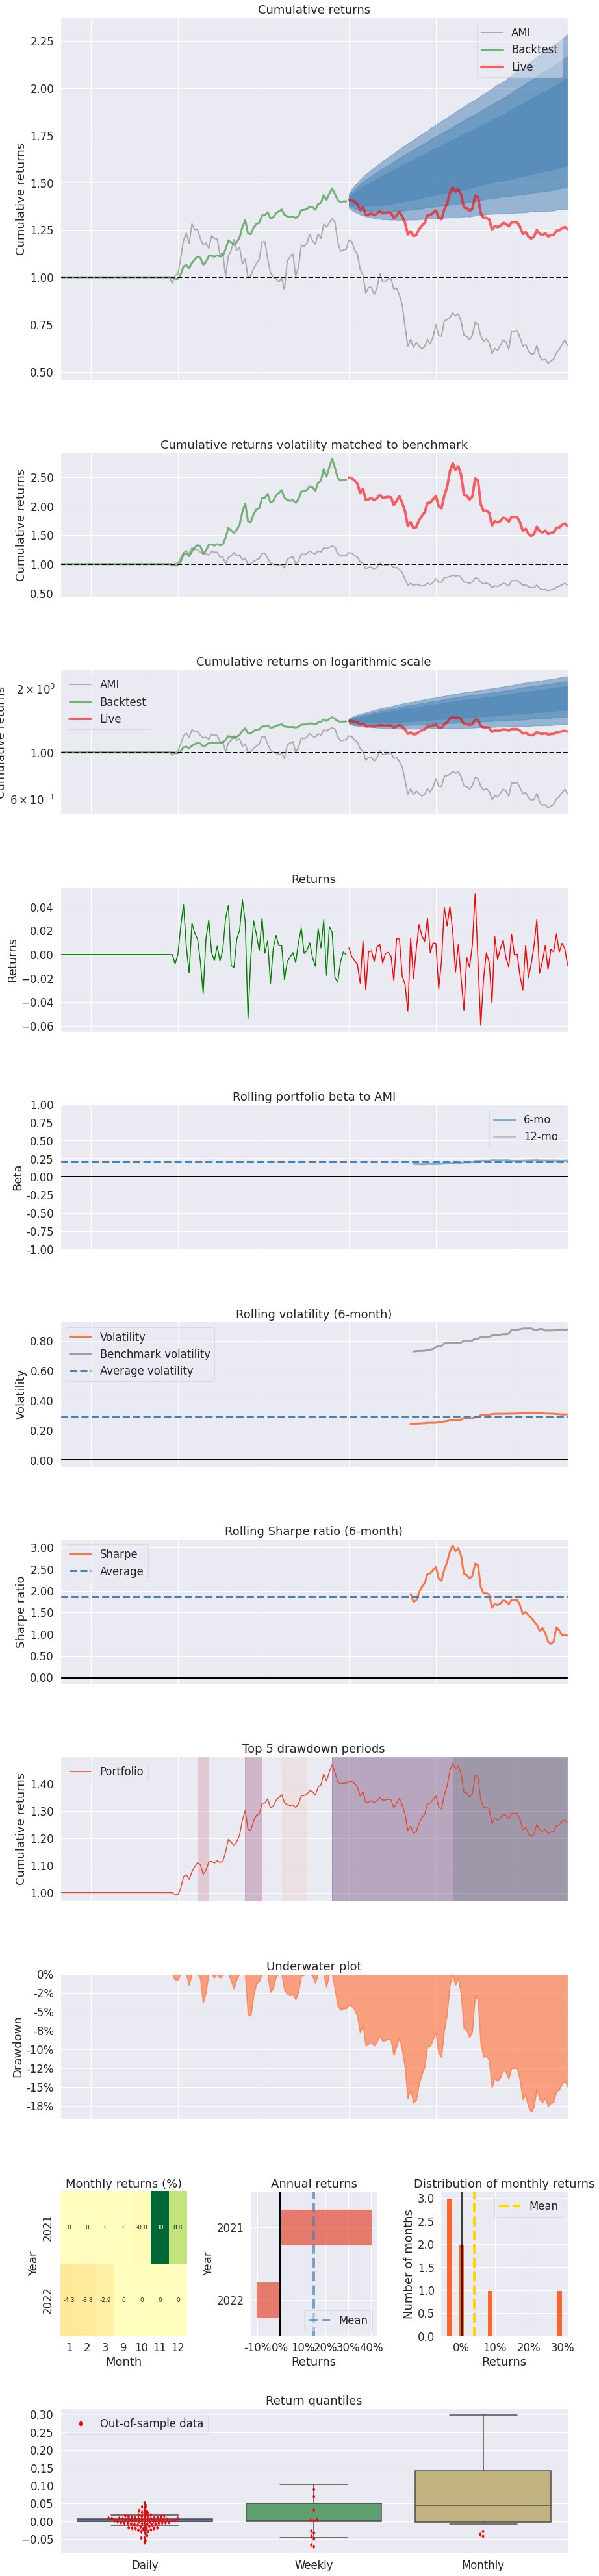

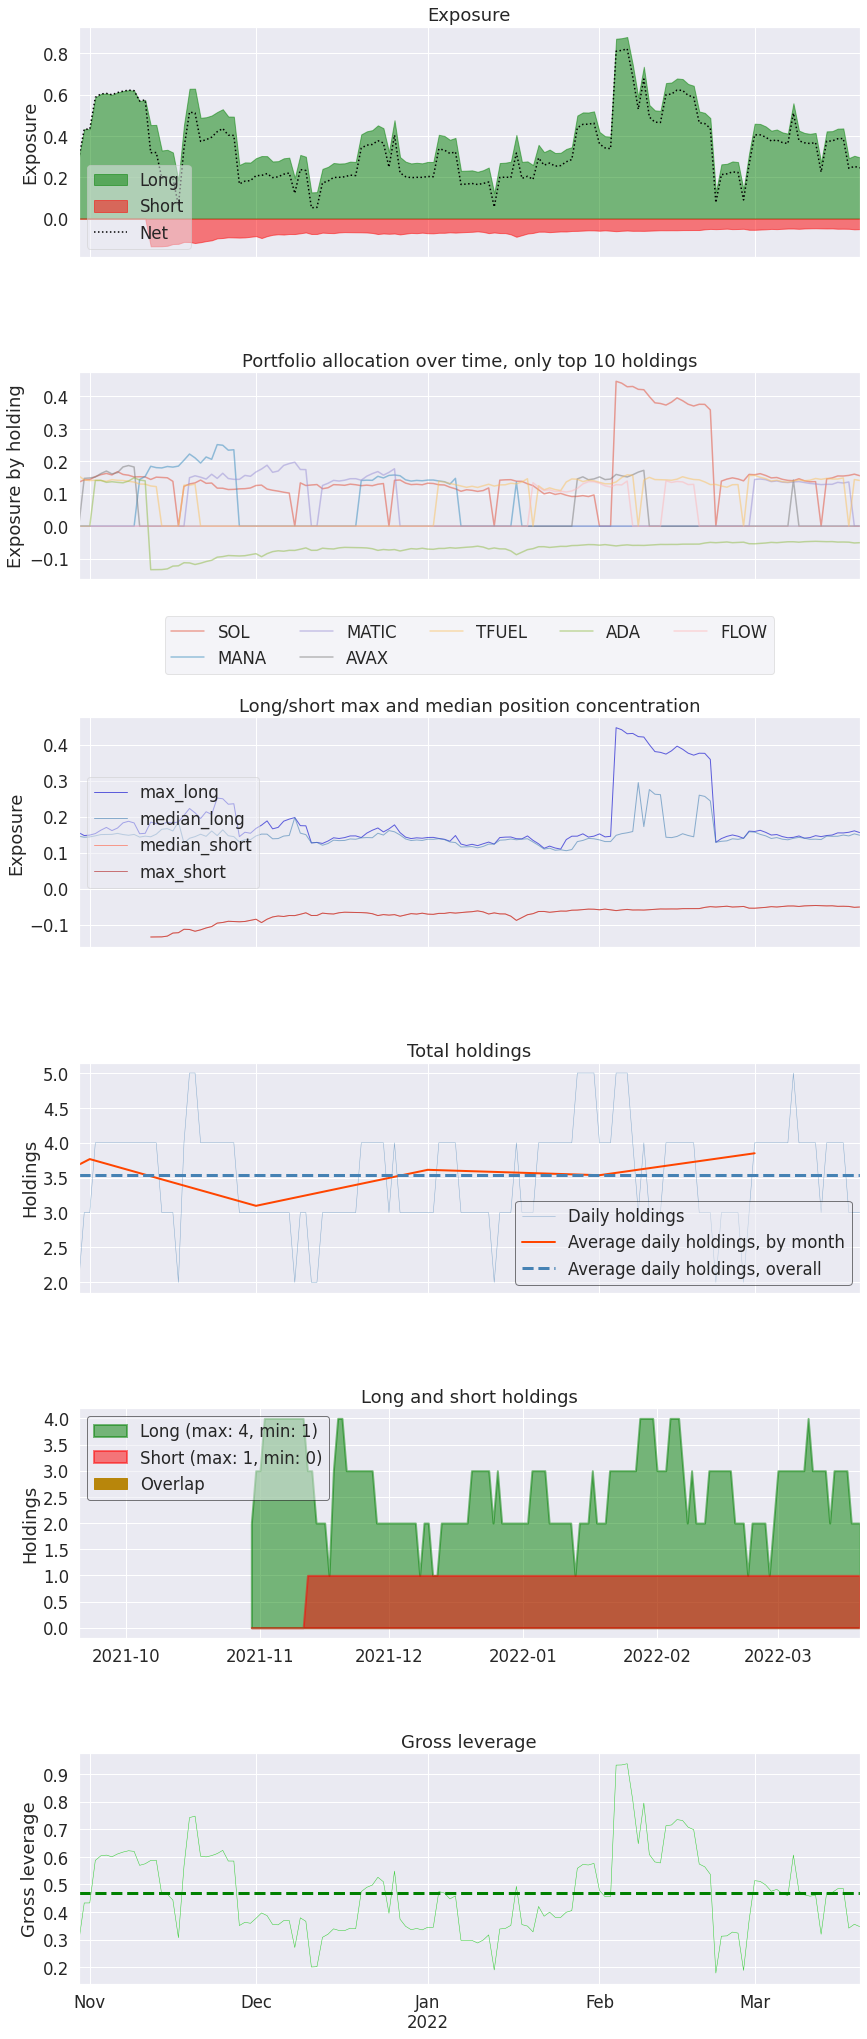

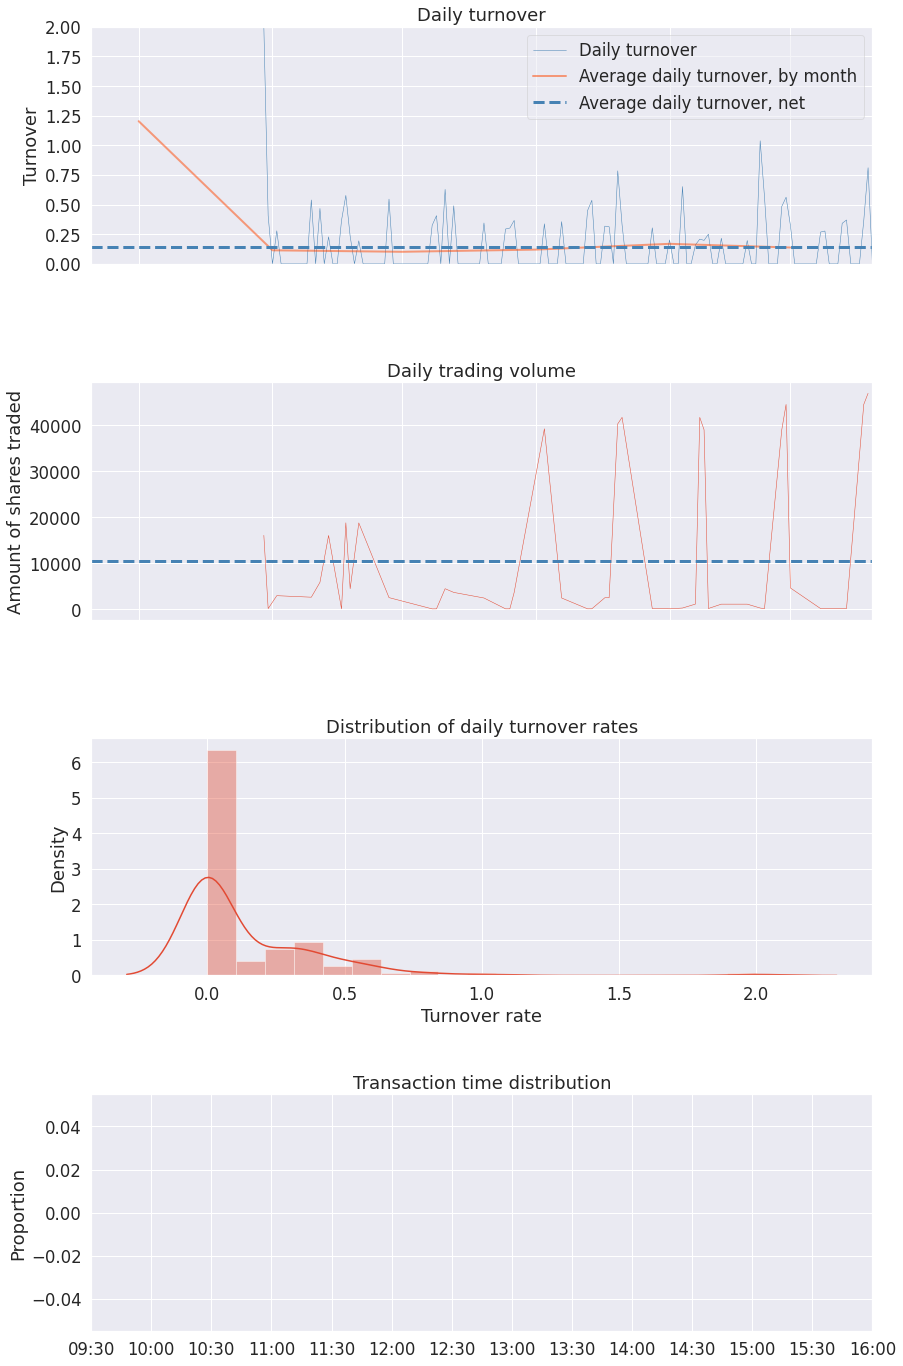

In [45]:
# Extract algo returns and benchmark returns
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
benchmark_period_return = perf.AMI.pct_change().fillna(0).add(1).cumprod().sub(1)

# Convert benchmark returns to daily returns
#daily_returns = (1 + benchmark_period_return) / (1 + benchmark_period_return.shift()) - 1
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1

# Create tear sheet
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns,live_start_date = '2022-01-01')

With the annual and monthly return plots, you can see which years and months the algorithm performed the best in. For instance, in the monthly heatmap plot, this algorithm performed the best in March 2021 (shaded in dark green). In a backtest with a longer period of time, these plots will reveal more information. Furthermore, the distribution of the monthly returns is also instructive in gauging how the algorithm performs in different periods throughout the year and if it is affected by seasonal patterns.

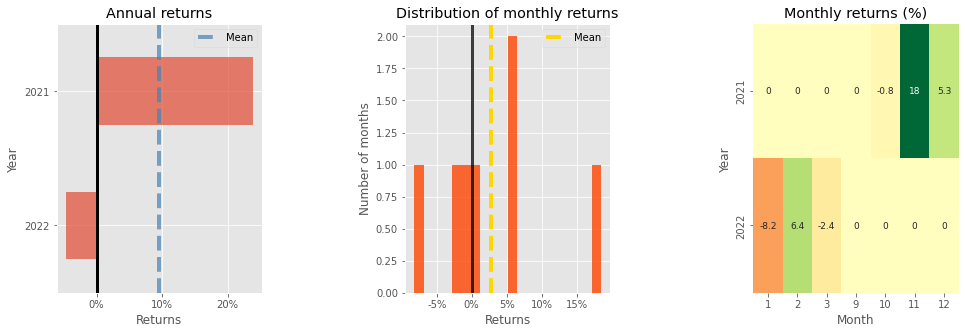

In [137]:
fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_annual_returns(returns)
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(returns)
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(returns)
plt.tight_layout()
fig.set_size_inches(15,5)

### Return Quantiles
These box and whisker plots provide an overview of the return quantiles broken down by the return timeframe (daily / weekly / monthly) across the entire backtest time period.

In [ ]:
pf.plot_return_quantiles(returns)

The center line in the middle of each box shows the median return, and the box shows the first quartile (25th percentile) as well as the 3rd quartile (75th percentile). While a high median return is always helpful, it is also important to understand the returns distribution. A tight box means that the bulk of the returns (25th - 75th percentile) fall within a tight bound - i.e. the returns are consistent and not volatile. A larger box means that the returns are more spread out. It is important, however, to take note of the scale to the left to put the quartiles in perspective. In addition, returns over longer periods of time will have a wider distribution as increasing the length of time increases the variability in returns.

The 'whiskers' at the end indicate the returns which fall outside the 25th and 75th percentile. A tight box with long whiskers indicate that there may be outliers in the returns - which may not be ideal if the outliers are negative. This may indicate that your strategy may be susceptible to certain market conditions / time periods.

Below, we have several rolling plots which show how an estimate changes throughout backtest period. In the case of the rolling beta and the rolling Sharpe ratio, the rolling estimate gives us more information than single point estimate for the entire period. A rolling estimate allows the user to see if the risk-adjusted return of the algorithm (Sharpe ratio) is consistent over time or if it fluctuates significantly. A volatile Sharpe ratio may indicate that the strategy may be riskier at certain time points or that it does not perform as well at these time points. Likewise, a volatile rolling beta indicates that it is exposed to the market during certain time points - if the strategy is meant to be market neutral, this could be a red flag.

### Rolling Beta Plot
The plot below shows the rolling beta of the strategy against benchmark returns over the entire period of the backtest. In this instance, the benchmark return of the SPY was used. Thus, the lower the rolling portfolio beta to the AMI, the more market neutral an algorithm is.

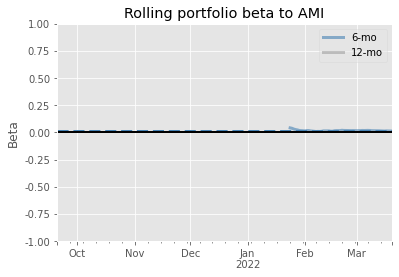

In [46]:
pf.plot_rolling_beta(returns, benchmark_rets);

### Rolling Sharpe Ratio Plot
The plot below shows the rolling Sharpe ratio over the period of the backtest. This allows you to understand the performance of the algorithm at different time points.

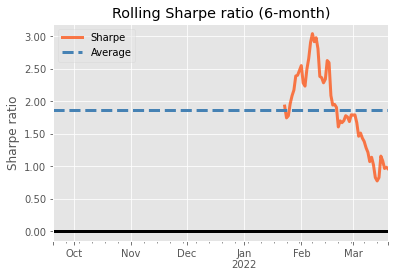

In [47]:
pf.plot_rolling_sharpe(returns);

### Drawdown Plots
In this plot, we visualize the drawdown chart described above. This chart provides an overview of the worst drawdown periods in the backtest. These periods show the time windows in the backtest in which the top 10 drawdowns occurred.

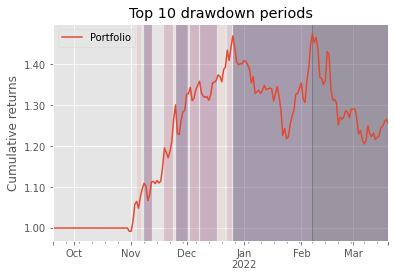

In [48]:
pf.plot_drawdown_periods(returns);

This, coupled with the underwater plot, allows for a quick check into the time periods during which the algorithm struggles. Generally speaking, the less volatile an algorithm is, the more minimal the drawdowns.

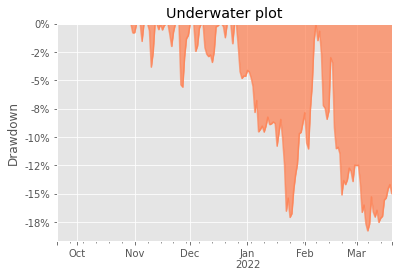

In [50]:
pf.plot_drawdown_underwater(returns);

### Gross Leverage
Gross leverage is the sum of long and short leverage exposure per share divided by net asset value. This plot allows you to see the amount of leverage being applied to the portfolio over the backtest period.

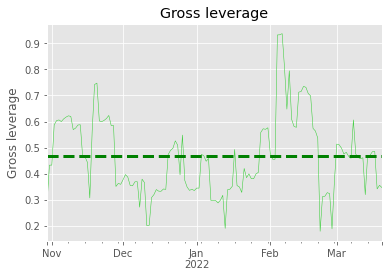

In [56]:
pf.plot_gross_leverage(returns, positions);

Monitoring the leverage of a strategy is important as it affects how you trade on margin. Unlike discretionary strategies where you could actively increase or decrease the leverage used in going long or short, algorithmic strategies automatically apply leverage during trading. Therefore, it is useful to monitor the gross leverage plot to ensure that the amount of leverage that your strategy uses is within the limits that you are comfortable with.

Good strategies generally start with an initial leverage of 1. Upon finding out the viability of the strategy by examining the Sharpe ratio and other metrics, leverage can be increased or decreased accordingly. A lower Sharpe ratio indicates that the strategy has a higher volatility per unit return, making it more risky to lever up. On the other hand, a higher Sharpe ratio indicates lower volatility per unit return, allowing you to increase the leverage and correspondingly, returns.

## Positions Plots

### Top Long and Short Positions
The tables below list the top 10 long and short positions of all time. The goal of each algorithm is to minimize the proportion of the portfolio invested in each security at any time point. This prevents the movement of any individual security from having a significant impact on the portfolio as a whole. The bigger the exposure a strategy has to any security, the greater the risk.

Generally, the biggest failure point for many strategies is high portfolio concentration in a few securities. While this may produce significant positive returns over a given time period, the converse can easily occur. Huge swings in a small number of equities would result in significant drawdowns. Good strategies tend to be those in which no security comprises more than 10% of the portfolio.


Top 10 long positions of all time,max
sid,
SOL,44.67%
MANA,25.16%
MATIC,19.75%
AVAX,18.71%
TFUEL,15.85%
ADA,14.95%
FLOW,14.01%


Top 10 short positions of all time,max
sid,
ADA,-13.39%


Top 10 positions of all time,max
sid,
SOL,44.67%
MANA,25.16%
MATIC,19.75%
AVAX,18.71%
TFUEL,15.85%
ADA,14.95%
FLOW,14.01%


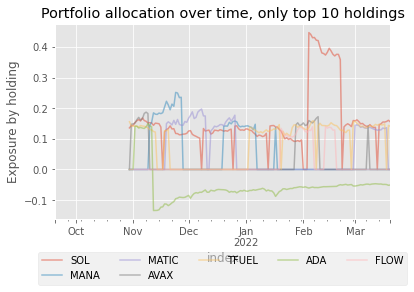

In [51]:
pos_percent = pf.pos.get_percent_alloc(positions)
pf.plotting.show_and_plot_top_positions(returns, pos_percent);

### Holdings Per Day
The holdings per day allows us to gain an insight into whether the total portfolio holdings fluctuate from day to day. This plot provides a good sanity check as to whether the algorithm is performing as it should, or if there were any bugs which should be fixed. For instance, we can use to holdings plot to check if the trading behavior is expected, i.e. if there are extended periods in which the number of holdings is exceptionally low or if that the algorithm is not trading.

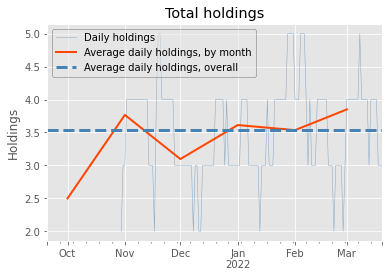

In [57]:
pf.plot_holdings(returns, positions);

## Transaction Plots
### Daily Turnover
This plot reflects how many coins are traded as a fraction of total coins. The higher the daily turnover, the higher the transaction costs associated with the algorithm. However, this also means that the returns and risk metrics are better able to capture the underlying performance of the algorithm as the higher quantity of trades provides more samples (of returns, risk, etc.) to draw from. This would in turn give a better estimation on Out of Sample periods as well.

<AxesSubplot:title={'center':'Daily turnover'}, ylabel='Turnover'>

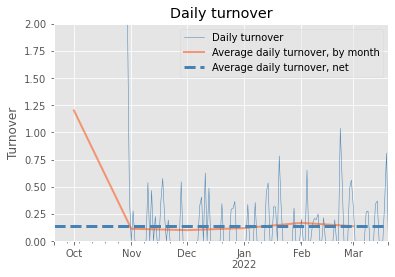

In [59]:
pf.plot_turnover(returns,transactions, positions)

Likewise, the Daily Turnover Histogram gives you an overview of the distribution of the turnover of your portfolio. This shows you both the average daily turnover of your portfolio and any outlier trading days.

/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


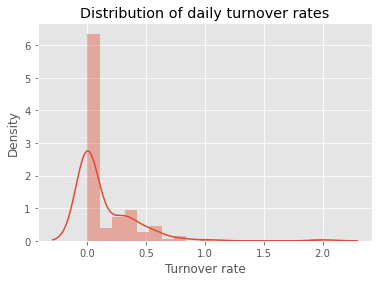

In [60]:
pf.plotting.plot_daily_turnover_hist(transactions, positions);